# H&M Capstone 3 project - Preprocessing and Modeling

## The business problem is classifying new products into an existing taxonomy of product categories for online retail stores such as H&M

### Product category is the variable we want to predict

- Features include product title, product description, one product image per row
- Each product has a unique article ID which is set as the index of the dataframe

In the previous notebook, data wrangling and exploratory data analysis was done 
The major product categories we would like to predict have been chosen. 
A key issue with keeping color variants of products is that these products are very similar to each other, and we want to keep them together and not have them assigned to both training and testing data. To deal with this issue, some preprocessing is done to treat the color variants as a single product, and by extension recompute the imbalanced class of products belonging to each product category.


### This notebook covers the scope of preprocessing and modeling 
1. Removing duplicate image embeddings
2. Train test split using GroupShuffleSplit (30% testing)
3. Create a Bag of words with tokenization of the product title and product description
    - Strip punctuation
    - Create tokens using tokenization
    - Count the number of tokens (take out stopwords)
4. Machine Learning Models with performance metrics
    - Stochastic Gradient Descent Classifier (SGDC)
    - XGBoost Classifier
    - KNN 
5. Artificial Neural Networks
6. Results and interpretation
    - Model metrics and results
    - Feature exploration and interpretability
    - Applications of the model for H&M stakeholders

## Imports

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import svm
import xgboost as xgb

import base64
from PIL import Image
from io import BytesIO
from IPython.core.display import HTML

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/pandabear/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pandabear/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
MAX_DICT_SIZE = 100
# Use all rows in NUM_ROWS is None
NUM_ROWS = None

## Load the data


In [3]:
df_h_and_m = pd.read_csv('/Users/pandabear/springboard/H_and_M_product_category_classification/data/interim/H_and_M_dataset.csv', index_col='article_id')
if NUM_ROWS:
    df = df_h_and_m[:NUM_ROWS]
else:
    df = df_h_and_m

In [4]:
df.head()

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,502,503,504,505,506,507,508,509,510,511
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,...,0.283601,0.502333,0.815049,0.183200,1.749047,1.393814,0.003090,3.470509,0.953905,1.414786
108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,...,0.369955,0.305547,0.750164,0.278698,3.498078,1.059729,0.080655,0.457405,0.473151,1.298293
108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,...,0.673954,1.023912,1.220658,0.990421,0.603554,1.449252,0.105316,2.191562,2.410787,0.329729
110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,...,0.443555,2.535063,0.854901,0.170298,0.000000,5.164192,2.344141,1.108159,0.782095,0.245456
110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,...,1.739273,1.536174,0.807216,0.026798,0.012599,3.243781,1.929202,0.880281,2.152518,1.053739


In [5]:
print(f'df size: {df.shape}')

df size: (99332, 537)


In [6]:
df.columns

Index(['product_code', 'prod_name', 'product_type_no', 'product_type_name',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id',
       ...
       '502', '503', '504', '505', '506', '507', '508', '509', '510', '511'],
      dtype='object', length=537)

In [7]:
# Drop unused columns
#'product_code'
cols_to_drop = ['product_type_no',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name','perceived_colour_master_id',
               'perceived_colour_master_name','department_no','department_name','index_code','index_name',
                'index_group_no','index_group_name','section_no','section_name','garment_group_no','garment_group_name']
df.drop(cols_to_drop, axis=1, inplace=True)

In [8]:
df.head()

,product_code,prod_name,product_type_name,detail_desc,product_title,0,1,2,3,4,...,502,503,504,505,506,507,508,509,510,511
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,108775,Strap top,Vest top,Jersey top with narrow shoulder straps.,"['strap', 'top']",1.671856,0.076411,1.992960,0.515366,0.087093,...,0.283601,0.502333,0.815049,0.183200,1.749047,1.393814,0.003090,3.470509,0.953905,1.414786
108775044,108775,Strap top,Vest top,Jersey top with narrow shoulder straps.,"['strap', 'top']",0.317337,0.022370,0.790894,0.184620,0.122858,...,0.369955,0.305547,0.750164,0.278698,3.498078,1.059729,0.080655,0.457405,0.473151,1.298293
108775051,108775,Strap top (1),Vest top,Jersey top with narrow shoulder straps.,"['strap', 'top', '(1)']",0.972625,0.119625,2.423473,1.054603,0.002196,...,0.673954,1.023912,1.220658,0.990421,0.603554,1.449252,0.105316,2.191562,2.410787,0.329729
110065001,110065,OP T-shirt (Idro),Bra,"Microfibre T-shirt bra with underwired, moulde...","['op', 't-shirt', '(idro)']",0.715175,0.000000,1.995459,0.098002,0.026993,...,0.443555,2.535063,0.854901,0.170298,0.000000,5.164192,2.344141,1.108159,0.782095,0.245456
110065002,110065,OP T-shirt (Idro),Bra,"Microfibre T-shirt bra with underwired, moulde...","['op', 't-shirt', '(idro)']",1.627883,0.009426,0.193758,1.295485,0.028507,...,1.739273,1.536174,0.807216,0.026798,0.012599,3.243781,1.929202,0.880281,2.152518,1.053739


In [9]:
df.isna().sum()

product_code           0
prod_name              0
product_type_name      0
detail_desc          369
product_title          0
                    ... 
507                    0
508                    0
509                    0
510                    0
511                    0
Length: 517, dtype: int64

Since the only column missing information is the product description, this is ok to keep.

In [10]:
# Convert the product description null values to empty strings
df['detail_desc'].fillna('',inplace=True)

In [11]:
df.isna().sum()

product_code         0
prod_name            0
product_type_name    0
detail_desc          0
product_title        0
                    ..
507                  0
508                  0
509                  0
510                  0
511                  0
Length: 517, dtype: int64

## 1. Check the number of duplicates for image embeddings
In the data wrangling stage we checked for exact duplicates, but this check is to see if there are images that are the same but have slightly different product titles/descriptions.

In [12]:
image_cols = [str(num) for num in range(512)]
image_embeddings = df[image_cols]
duplicate_images = image_embeddings[image_embeddings.duplicated(keep=False) == True].sort_values(by='0')
print(f'There are a total of {duplicate_images.shape[0]} rows')
duplicate_images.head()

There are a total of 397 rows


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
article_id,,,,,,,,,,,,,,,,,,,,,
631450001,0.000000,0.718425,0.499194,3.073000,0.268538,0.143195,1.224393,1.212663,0.867520,2.828853,...,2.458086,2.350473,0.606510,0.488055,0.281623,0.522974,4.141664,0.633914,1.004539,0.687645
661686001,0.000000,0.718425,0.499194,3.073000,0.268538,0.143195,1.224393,1.212663,0.867520,2.828853,...,2.458086,2.350473,0.606510,0.488055,0.281623,0.522974,4.141664,0.633914,1.004539,0.687645
722475006,0.011881,0.018850,0.211799,0.402413,0.452787,0.771340,2.329740,0.108756,0.435526,0.403535,...,2.118542,0.241202,1.065701,0.674406,3.149235,0.872026,1.138089,0.835722,0.290696,1.262451
781758005,0.011881,0.018850,0.211799,0.402413,0.452787,0.771340,2.329740,0.108756,0.435526,0.403535,...,2.118542,0.241202,1.065701,0.674406,3.149235,0.872026,1.138089,0.835722,0.290696,1.262451
879086001,0.024319,0.031018,1.041525,1.254949,0.495849,0.010483,0.381270,1.058385,0.000000,0.584427,...,1.940401,0.010902,0.596070,0.006220,0.011655,0.327071,0.012588,0.685774,1.458734,6.389759


In [13]:
df.loc[631450001]

product_code                                                    631450
prod_name                                                   Jarl Dress
product_type_name                                                Dress
detail_desc          Sleeveless, A-line dress in airy, patterned ch...
product_title                                        ['jarl', 'dress']
                                           ...                        
507                                                           0.522974
508                                                           4.141664
509                                                           0.633914
510                                                           1.004539
511                                                           0.687645
Name: 631450001, Length: 517, dtype: object

In [14]:
df.loc[661686001]

product_code                                                    661686
prod_name                                                ES JARL DRESS
product_type_name                                                Dress
detail_desc          Sleeveless, A-line dress in airy, patterned ch...
product_title                                  ['es', 'jarl', 'dress']
                                           ...                        
507                                                           0.522974
508                                                           4.141664
509                                                           0.633914
510                                                           1.004539
511                                                           0.687645
Name: 661686001, Length: 517, dtype: object

Looking at these shows they are the same product with the same product description and image. Remove these duplicates from the dataset. 

In [15]:
df.drop(duplicate_images.index, inplace=True)

In [16]:
df.shape

(98935, 517)

In [17]:
# Separate out the product class from the product title and product description
y = df['product_type_name']
X = df

In [18]:
y

article_id
108775015    Vest top
108775044    Vest top
108775051    Vest top
110065001         Bra
110065002         Bra
               ...   
952938001         Top
953450001       Socks
953763001    Vest top
956217002       Dress
959461001       Dress
Name: product_type_name, Length: 98935, dtype: object

In [19]:
product_cat = list(y.unique())
len(product_cat)

44

In [20]:
X.head()

,product_code,prod_name,product_type_name,detail_desc,product_title,0,1,2,3,4,...,502,503,504,505,506,507,508,509,510,511
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,108775,Strap top,Vest top,Jersey top with narrow shoulder straps.,"['strap', 'top']",1.671856,0.076411,1.992960,0.515366,0.087093,...,0.283601,0.502333,0.815049,0.183200,1.749047,1.393814,0.003090,3.470509,0.953905,1.414786
108775044,108775,Strap top,Vest top,Jersey top with narrow shoulder straps.,"['strap', 'top']",0.317337,0.022370,0.790894,0.184620,0.122858,...,0.369955,0.305547,0.750164,0.278698,3.498078,1.059729,0.080655,0.457405,0.473151,1.298293
108775051,108775,Strap top (1),Vest top,Jersey top with narrow shoulder straps.,"['strap', 'top', '(1)']",0.972625,0.119625,2.423473,1.054603,0.002196,...,0.673954,1.023912,1.220658,0.990421,0.603554,1.449252,0.105316,2.191562,2.410787,0.329729
110065001,110065,OP T-shirt (Idro),Bra,"Microfibre T-shirt bra with underwired, moulde...","['op', 't-shirt', '(idro)']",0.715175,0.000000,1.995459,0.098002,0.026993,...,0.443555,2.535063,0.854901,0.170298,0.000000,5.164192,2.344141,1.108159,0.782095,0.245456
110065002,110065,OP T-shirt (Idro),Bra,"Microfibre T-shirt bra with underwired, moulde...","['op', 't-shirt', '(idro)']",1.627883,0.009426,0.193758,1.295485,0.028507,...,1.739273,1.536174,0.807216,0.026798,0.012599,3.243781,1.929202,0.880281,2.152518,1.053739


## 2. Train test split using `GroupShuffleSplit`
In order to stratify the training and testing groups to keep the class distributions, iterate through each major category and perform the train test split before combining together at the end. 

In [21]:
major_categories = list(y.unique())
len(major_categories)

44

In [22]:
X[X['product_type_name'] == 'Trousers']

,product_code,prod_name,product_type_name,detail_desc,product_title,0,1,2,3,4,...,502,503,504,505,506,507,508,509,510,511
article_id,,,,,,,,,,,,,,,,,,,,,
118458003,118458,Jerry jogger bottoms,Trousers,Trousers in sweatshirt fabric with an elastica...,"['jerry', 'jogger', 'bottoms']",0.716394,0.075119,0.760964,0.005293,0.043165,...,1.710137,0.161567,1.758242,2.400354,2.786823,0.185599,0.154776,0.084731,1.128053,0.335465
118458004,118458,Jerry jogger bottoms,Trousers,Trousers in sweatshirt fabric with an elastica...,"['jerry', 'jogger', 'bottoms']",0.467674,0.349229,1.187908,0.001379,0.009257,...,2.415857,0.125726,1.782201,0.772446,1.151965,0.000000,0.028152,0.109547,1.146076,1.055916
118458028,118458,Jerry jogger bottoms,Trousers,Trousers in sweatshirt fabric with an elastica...,"['jerry', 'jogger', 'bottoms']",0.505302,0.098685,0.863102,0.012828,0.000000,...,1.749923,0.669983,2.158863,1.836127,2.255550,0.000000,0.002361,0.051746,0.725937,0.149517
118458029,118458,Jerry jogger bottoms,Trousers,Trousers in sweatshirt fabric with an elastica...,"['jerry', 'jogger', 'bottoms']",0.977072,0.179591,1.739979,0.001439,0.116781,...,2.783303,0.207692,1.762935,2.163352,1.678695,0.261190,0.098641,0.129057,2.242395,0.105637
118458034,118458,Jerry jogger bottoms,Trousers,Trousers in sweatshirt fabric with an elastica...,"['jerry', 'jogger', 'bottoms']",1.128840,0.365160,0.754004,0.007041,0.068296,...,2.260975,0.004690,1.330592,0.924240,1.470124,0.038173,0.214037,0.000129,0.708456,0.080143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939549002,939549,Bug sweatpants,Trousers,Trousers in organic cotton sweatshirt fabric. ...,"['bug', 'sweatpants']",0.471608,0.186702,1.369552,0.420079,0.154091,...,2.398601,0.165494,1.545648,1.017157,1.784314,0.085338,0.664818,0.438292,1.434357,1.031537
939549003,939549,Bug sweatpants,Trousers,Trousers in organic cotton sweatshirt fabric. ...,"['bug', 'sweatpants']",1.235076,0.244258,1.102187,0.049837,0.087579,...,1.589029,0.012065,1.610216,1.127236,2.905157,0.052370,0.293558,0.037477,0.798054,0.534921
943097001,943097,Sandra HW Wide Trousers 1,Trousers,High-waisted trousers in a linen and cotton we...,"['sandra', 'hw', 'wide', 'trousers', '1']",0.337960,0.380445,1.195167,0.204249,0.143932,...,2.037740,0.301228,1.042933,0.683958,0.595333,0.029143,0.005006,0.032072,0.380500,0.752359


In [23]:
# Initiate empty X_train, y_train, X_test and y_test dataframes
X_train,  X_test = pd.DataFrame(), pd.DataFrame()
y_train, y_test = list(), list()

# Iterate over each category so the class distribution is maintained (in lieu of stratify which isn't part of GroupShuffleSplit)
for cat in major_categories:
    X_cat = X[X['product_type_name'] == cat]
    y_cat = y[X_cat.index]
    
    # Do the splitting based on the group `product_code` which is the same for color variants
    gs = GroupShuffleSplit(n_splits=1, test_size=.3, random_state=0)
    train_ix, test_ix = next(gs.split(X_cat, y_cat, groups=X_cat.product_code))
        
    # index the dataframe to create the train and test sets 
    X_train_cat = X_cat.iloc[train_ix]
    y_train_cat = y_cat.iloc[train_ix]
    X_test_cat = X_cat.iloc[test_ix]
    y_test_cat = y_cat.iloc[test_ix]
    
    # Concatenate dataframes
    X_train = pd.concat([X_train,X_train_cat], axis=0)
    y_train.extend(y_train_cat)
    X_test = pd.concat([X_test,X_test_cat], axis=0)
    y_test.extend(y_test_cat)
    

### Check class distributions to check imbalanced classes
This should look similar to the bar graph from the EDA notebook

In [24]:
# Represent the product categories as a percentage (don't include color variants) before training/testing split
no_color_variants = X.groupby('product_code').first()
df_size = no_color_variants.shape[0]

original_class_percentages = pd.DataFrame([(x/df_size) * 100.00 for x in no_color_variants.product_type_name.value_counts()], index=no_color_variants.product_type_name.value_counts().index)
original_class_percentages.columns = ['Percentage']
original_class_percentages = original_class_percentages.reset_index()
original_class_percentages

,index,Percentage
0,Dress,12.549936
1,Trousers,10.586526
2,Sweater,8.171418
3,Jacket,5.229708
4,T-shirt,4.884692
5,Blouse,4.653169
6,Top,4.215090
7,Skirt,3.579535
8,Shorts,3.493281
9,Shirt,3.037044


In [25]:
no_color_variants_train = X_train.groupby('product_code').first()
no_color_variants_test = X_test.groupby('product_code').first()

In [26]:
print(no_color_variants.shape)
print(no_color_variants_train.shape)
print(no_color_variants_test.shape)


(44056, 516)
(30862, 516)
(13269, 516)


In [27]:
# Represent the product categories as a percentage (don't include color variants)
class_percentages_train = pd.DataFrame([(x / no_color_variants_train.shape[0]) * 100.00 for x in no_color_variants_train.product_type_name.value_counts()], index=no_color_variants_train.product_type_name.value_counts().index)
class_percentages_train.columns = ['Percentage']
class_percentages_train = class_percentages_train.reset_index()
class_percentages_train

,index,Percentage
0,Dress,12.546173
1,Trousers,10.576113
2,Sweater,8.201024
3,Jacket,5.226492
4,T-shirt,4.870067
5,Blouse,4.646491
6,Top,4.231741
7,Skirt,3.583695
8,Shorts,3.489728
9,Shirt,3.032856


In [28]:
class_percentages_test = pd.DataFrame([(x / no_color_variants_test.shape[0]) * 100.00 for x in no_color_variants_test.product_type_name.value_counts()], index=no_color_variants_test.product_type_name.value_counts().index)
class_percentages_test.columns = ['Percentage']
class_percentages_test = class_percentages_test.reset_index()
class_percentages_test


,index,Percentage
0,Dress,12.517899
1,Trousers,10.558444
2,Sweater,8.176954
3,Jacket,5.192554
4,T-shirt,4.876027
5,Blouse,4.634863
6,Top,4.250509
7,Skirt,3.572236
8,Shorts,3.489336
9,Shirt,3.029618


[Text(0, 0, 'Dress'),
 Text(1, 0, 'Trousers'),
 Text(2, 0, 'Sweater'),
 Text(3, 0, 'Jacket'),
 Text(4, 0, 'T-shirt'),
 Text(5, 0, 'Blouse'),
 Text(6, 0, 'Top'),
 Text(7, 0, 'Skirt'),
 Text(8, 0, 'Shorts'),
 Text(9, 0, 'Shirt'),
 Text(10, 0, 'Vest top'),
 Text(11, 0, 'Bra'),
 Text(12, 0, 'Earring'),
 Text(13, 0, 'Sneakers'),
 Text(14, 0, 'Bag'),
 Text(15, 0, 'Underwear bottom'),
 Text(16, 0, 'Garment Set'),
 Text(17, 0, 'Hoodie'),
 Text(18, 0, 'Cardigan'),
 Text(19, 0, 'Jumpsuit/Playsuit'),
 Text(20, 0, 'Leggings/Tights'),
 Text(21, 0, 'Hat/beanie'),
 Text(22, 0, 'Other accessories'),
 Text(23, 0, 'Boots'),
 Text(24, 0, 'Blazer'),
 Text(25, 0, 'Socks'),
 Text(26, 0, 'Swimwear bottom'),
 Text(27, 0, 'Scarf'),
 Text(28, 0, 'Hair/alice band'),
 Text(29, 0, 'Necklace'),
 Text(30, 0, 'Pyjama set'),
 Text(31, 0, 'Swimsuit'),
 Text(32, 0, 'Sandals'),
 Text(33, 0, 'Bikini top'),
 Text(34, 0, 'Bodysuit'),
 Text(35, 0, 'Sunglasses'),
 Text(36, 0, 'Coat'),
 Text(37, 0, 'Belt'),
 Text(38, 0, 'Cap/p

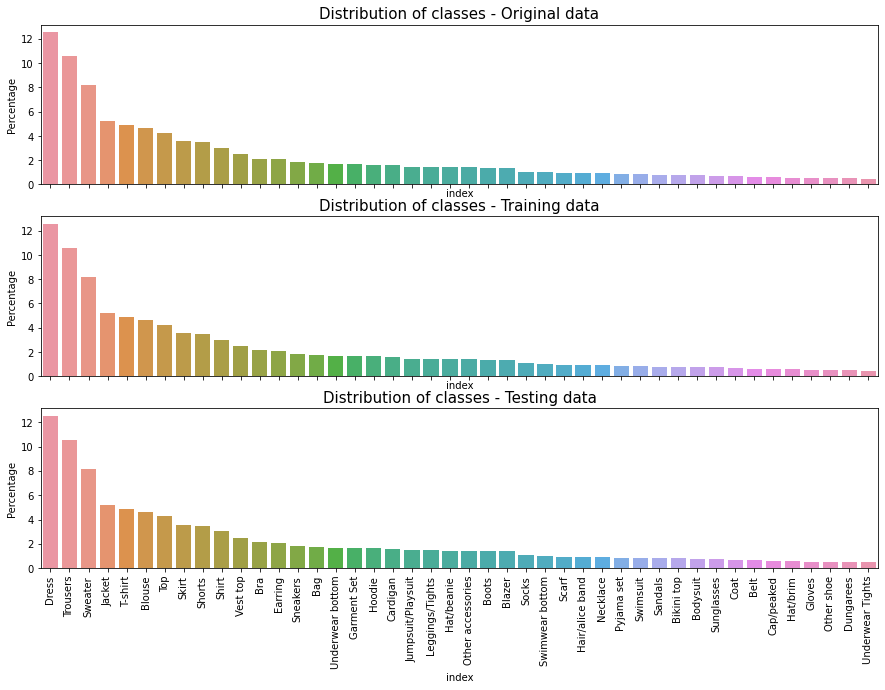

In [29]:
# Compare the training and testing class distributions
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(15,10))

sns.barplot(x='index', y='Percentage', data=original_class_percentages, ax=axes[0])
sns.barplot(x='index', y='Percentage', data=class_percentages_train, ax=axes[1])
sns.barplot(x='index', y='Percentage', data=class_percentages_test, ax=axes[2])

axes[0].set_title('Distribution of classes - Original data', size = 15)
axes[1].set_title('Distribution of classes - Training data', size = 15)
axes[2].set_title('Distribution of classes - Testing data', size = 15)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=90)

The class distributions between training and testing look similar, and are similar to the class distribution before training/testing split.

In [30]:
# Drop the product categories and product_code from X_train and X_test
X_train.drop(['product_type_name','product_code'], axis=1, inplace=True)
X_test.drop(['product_type_name','product_code'], axis=1, inplace=True)

In [31]:
X_test.head()

,prod_name,detail_desc,product_title,0,1,2,3,4,5,6,...,502,503,504,505,506,507,508,509,510,511
article_id,,,,,,,,,,,,,,,,,,,,,
194270002,HELENA 2-pack tanktop,Tops in soft organic cotton jersey.,"['helena', '2-pack', 'tanktop']",1.620172,0.140583,0.715644,1.140085,0.141574,0.181567,0.266037,...,0.245893,0.083284,0.433086,0.142297,3.915074,2.237202,0.329445,1.800650,0.343067,1.338163
194270044,HELENA 2-pack tanktop,Tops in soft organic cotton jersey.,"['helena', '2-pack', 'tanktop']",0.320825,0.479506,0.718964,0.042605,0.000000,0.081761,0.623028,...,0.194123,0.177390,0.373834,0.565914,4.546570,1.408547,0.297990,1.143682,0.491720,0.764727
194270045,HELENA 2-pack tanktop,Tops in soft organic cotton jersey.,"['helena', '2-pack', 'tanktop']",1.010420,0.091721,2.454683,0.907387,0.221087,0.308097,0.050207,...,0.022513,1.019517,0.700108,0.753436,0.869249,0.686492,0.169349,2.235411,0.166975,0.287730
194270046,HELENA 2-pack tanktop,Tops in soft organic cotton jersey.,"['helena', '2-pack', 'tanktop']",1.020009,0.144256,1.613463,0.537956,0.021299,0.000000,0.799791,...,0.129377,0.000000,1.011267,0.474510,2.779674,1.406441,0.267501,0.953895,1.188455,1.242071
200761022,TORKEL Basic 2-pack tanktop SB,"Vest tops in soft, ribbed organic cotton jersey.","['torkel', 'basic', '2-pack', 'tanktop', 'sb']",0.336212,0.256347,1.347251,0.027180,0.021341,0.318473,1.101777,...,0.584963,0.074544,0.964144,0.438821,2.869375,1.695073,0.000000,1.874219,1.205408,0.610394


In [32]:
print(f'X_train size: {X_train.shape}')
print(f'X_test size: {X_test.shape}')
print(f'y_train length: {len(y_train)}')
print(f'y_test length: {len(y_test)}')

X_train size: (68848, 515)
X_test size: (30087, 515)
y_train length: 68848
y_test length: 30087


In [33]:
# # Use LabelEncoder from SKLearn to convert the product categories into numeric ones
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)
# y_train_encoded, y_test_encoded = list(y_train_encoded), list(y_test_encoded)

In [34]:
# y_test_encoded[:20]

In [35]:
# # Stratify the train test split on y so the distribution of product categories stays the same in training and testing
# X_train, X_test, y_train, y_test = train_test_split(X,
#                                                 y_encoded,
#                                                 train_size = 0.70,
#                                                 random_state = 42,
#                                                 stratify = y_encoded)




# print(f'X_train size: {X_train.shape}')
# print(f'X_test size: {X_test.shape}')
# print(f'y_train length: {len(y_train)}')
# print(f'y_test length: {len(y_test)}')

In [36]:
# Save the index to put back after preprocessing
X_train_index = X_train.index
X_test_index = X_test.index

## 3. Preprocessing text: Create a Bag of words with tokenization
Create a bag of words from the product title and product description, excluding stop words. Set the 'MAX_DICT_SIZE' to limit the number of words to use as features. 

In [38]:
# Example text
test_string = """Strap top Jersey top with narrow shoulder straps."""
product_index = "108775015"

# Text preprocessing steps include converting to lowercase, removing stop words and punctuation

def extract_bag_of_words(test_string):
    # Include everything that is alphabetical, no punctuation
    #tokens = [w for w in word_tokenize(str(test_string).lower()) if w.isalpha()]
    tokens = [w for w in str(test_string).lower().split() if w.isalpha()]
    no_stops = [t for t in tokens if t not in stopwords.words('english')]
    return no_stops

# Create a counter of all the words in the column 'combined_words'
def create_word_dict(X, MAX_DICT_SIZE, include_description):
    #all_words_dict = Counter(bag_of_words_df(X.combined_words.sum()))
    if include_description:
        all_words_dict = Counter(extract_bag_of_words(X.combined_words.values.tolist()))
    else:
        all_words_dict = Counter(extract_bag_of_words(X.prod_name.values.tolist()))
    
    # Set cutoff threshold to be 5 or more occurances
    threshold = 5

    truncated_words_dict = {key : value for key, value in all_words_dict.items() if value >= threshold}

    # Sort dictionary in descending order and cap at MAX_DICT_SIZE items

    sorted_truncated_words_list = sorted(truncated_words_dict.items(), key=lambda x: x[1], reverse=True)
    if len(sorted_truncated_words_list) > MAX_DICT_SIZE:
        sorted_truncated_words_list = sorted_truncated_words_list[:MAX_DICT_SIZE]
    return dict(sorted_truncated_words_list)


In [39]:
# Extract bag of words from product title (and also product description)

class BagOfWordsFeatureExtractor():
    def __init__(self, include_description):
        self.include_description = include_description
    
    
    def fit(self, X, y=None):
        # Create the word list to use in the transform step
        
        if self.include_description:
            # Combine product title with description
            X['combined_words'] = X['prod_name'] + " " + X['detail_desc'] 
            print('fit step 1')
            X['words_list'] = X.apply(lambda x: extract_bag_of_words(x['combined_words']), axis=1)
            print('fit step 2')
            self.all_words_dict = create_word_dict(X, MAX_DICT_SIZE, self.include_description)
            print('fit step 3')
            self.bag_of_word_column_names = list(self.all_words_dict.keys())
        else:
            X['words_list'] = X.apply(lambda x: extract_bag_of_words(x['prod_name']), axis=1)
            self.all_words_dict = create_word_dict(X, MAX_DICT_SIZE, self.include_description)
            self.bag_of_word_column_names = list(self.all_words_dict.keys())
            
        return self

    
    def transform(self, X):
        #print('start transform')
        # Do a row by row check to see if the word occurs in words_list
        # Initialize new columns and set values to 0
        #print('Before initializing columns to 0')
        for col in self.bag_of_word_column_names:
            X["_" + col] = 0
        
#         print('Completed initializing columns to 0')
        
        if self.include_description:
            X['combined_words'] = X['prod_name'] + " " + X['detail_desc'] 
            X['words_list'] = X.apply(lambda x: extract_bag_of_words(x['combined_words']), axis=1)
        else:
            X['words_list'] = X.apply(lambda x: extract_bag_of_words(x['prod_name']), axis=1)
            
        for i, index in enumerate(X.index):
#             if i%1000:
#                 print(f'Completed {i} rows')
            for word in X.loc[index,'words_list']:
                if word in self.bag_of_word_column_names:
                    X.loc[index,"_" + word] = 1
#         print('Completed initializing columns to 1')
        
        # Drop columns
        if self.include_description:
            X.drop(['combined_words','words_list'], axis=1, inplace=True)
        else:
            X.drop(['words_list'], axis=1, inplace=True)
#         print('Dropped columns')
        return X

### Consider 3 versions to compare model performance:
1. Image embeddings
2. Product title embeddings
3. Product title + product description embeddings
4. Product title + product description + image embeddings

### 1. Product category prediction using only image embeddings

In [40]:
# The image embedding column names are stored in a list
image_cols = [str(num) for num in range(512)]

X_train_image = X_train[image_cols]
X_test_image = X_test[image_cols]

### 2. NLP pipeline: Product title embeddings

In [41]:
bag_of_words_title = BagOfWordsFeatureExtractor(include_description = False)

p2 = Pipeline([
    ('bag_of_words_title', bag_of_words_title)])

# Product title embeddings
#time_start = time.time()
X_train_2 = p2.fit_transform(X_train)
#print(time.time() - time_start)

X_test_2 = p2.transform(X_test)

# Assign index back
X_train_2.index = X_train_index
X_test_2.index = X_test_index


/var/folders/5_/87js___11b5312gjj36qhf_m0000gn/T/ipykernel_77728/2358199283.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X["_" + col] = 0
/var/folders/5_/87js___11b5312gjj36qhf_m0000gn/T/ipykernel_77728/2358199283.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X["_" + col] = 0
/var/folders/5_/87js___11b5312gjj36qhf_m0000gn/T/ipykernel_77728/2358199283.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

In [42]:
X_train_2._shirt.sum()

1362

In [45]:
X_test_2.head()

,prod_name,detail_desc,product_title,0,1,2,3,4,5,6,...,_leather,_pull,_chino,_blouse,_straw,_cotton,_hoop,_ch,_printed,_trash
article_id,,,,,,,,,,,,,,,,,,,,,
194270002,HELENA 2-pack tanktop,Tops in soft organic cotton jersey.,"['helena', '2-pack', 'tanktop']",1.620172,0.140583,0.715644,1.140085,0.141574,0.181567,0.266037,...,0,0,0,0,0,0,0,0,0,0
194270044,HELENA 2-pack tanktop,Tops in soft organic cotton jersey.,"['helena', '2-pack', 'tanktop']",0.320825,0.479506,0.718964,0.042605,0.000000,0.081761,0.623028,...,0,0,0,0,0,0,0,0,0,0
194270045,HELENA 2-pack tanktop,Tops in soft organic cotton jersey.,"['helena', '2-pack', 'tanktop']",1.010420,0.091721,2.454683,0.907387,0.221087,0.308097,0.050207,...,0,0,0,0,0,0,0,0,0,0
194270046,HELENA 2-pack tanktop,Tops in soft organic cotton jersey.,"['helena', '2-pack', 'tanktop']",1.020009,0.144256,1.613463,0.537956,0.021299,0.000000,0.799791,...,0,0,0,0,0,0,0,0,0,0
200761022,TORKEL Basic 2-pack tanktop SB,"Vest tops in soft, ribbed organic cotton jersey.","['torkel', 'basic', '2-pack', 'tanktop', 'sb']",0.336212,0.256347,1.347251,0.027180,0.021341,0.318473,1.101777,...,0,0,0,0,0,0,0,0,0,0


### 3. NLP pipeline: Product title  + description embeddings

In [46]:
bag_of_words_title_desc = BagOfWordsFeatureExtractor(include_description = True)

# Create another set for Product title + product description embeddings
p3 = Pipeline([
    ('bag_of_words_title_desc', bag_of_words_title_desc)
])

X_train_3 = p3.fit_transform(X_train)
X_test_3 = p3.transform(X_test)

# Assign index back
X_train_3.index = X_train_index
X_test_3.index = X_test_index


fit step 1
fit step 2
fit step 3


/var/folders/5_/87js___11b5312gjj36qhf_m0000gn/T/ipykernel_77728/2358199283.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X["_" + col] = 0
/var/folders/5_/87js___11b5312gjj36qhf_m0000gn/T/ipykernel_77728/2358199283.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X["_" + col] = 0
/var/folders/5_/87js___11b5312gjj36qhf_m0000gn/T/ipykernel_77728/2358199283.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

In [47]:
# Remove the 2 original text columns + 512 image embedding columns
nlp_cols = list(X_train_2.columns)[515:]
X_train_2 = X_train_2[nlp_cols]
X_test_2 = X_test_2[nlp_cols]

In [48]:
X_train_2.head()

,_ls,_fancy,_hw,_slim,_ss,_dress,_tee,_price,_basic,_denim,...,_round,_washed,_buttoned,_loop,_functional,_welt,_slits,_mesh,_belt,_jeans
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108775044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108775051,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218354001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218354020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
X_train_2.sum()

_ls       1447
_fancy    1689
_hw        995
_slim      855
_ss        928
          ... 
_welt     2291
_slits    2296
_mesh     2017
_belt     1980
_jeans    1899
Length: 173, dtype: int64

In [50]:
X_test_2.head()

,_ls,_fancy,_hw,_slim,_ss,_dress,_tee,_price,_basic,_denim,...,_round,_washed,_buttoned,_loop,_functional,_welt,_slits,_mesh,_belt,_jeans
article_id,,,,,,,,,,,,,,,,,,,,,
194270002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194270044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194270045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194270046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200761022,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### 4. Product title + product description + image embeddings

In [51]:
X_train_full = X_train_3.drop(['prod_name','detail_desc','product_title'], axis=1)
X_test_full = X_test_3.drop(['prod_name','detail_desc','product_title'], axis=1)

# Do the same for the title + desc dataset
X_train_3 = X_train_3[nlp_cols]
X_test_3 = X_test_3[nlp_cols]

X_train_3.head()

,_ls,_fancy,_hw,_slim,_ss,_dress,_tee,_price,_basic,_denim,...,_round,_washed,_buttoned,_loop,_functional,_welt,_slits,_mesh,_belt,_jeans
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108775044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108775051,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218354001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218354020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
X_test_3.head()

,_ls,_fancy,_hw,_slim,_ss,_dress,_tee,_price,_basic,_denim,...,_round,_washed,_buttoned,_loop,_functional,_welt,_slits,_mesh,_belt,_jeans
article_id,,,,,,,,,,,,,,,,,,,,,
194270002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194270044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194270045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194270046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200761022,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
X_train_2.isna().sum()

_ls       0
_fancy    0
_hw       0
_slim     0
_ss       0
         ..
_welt     0
_slits    0
_mesh     0
_belt     0
_jeans    0
Length: 173, dtype: int64

In [54]:
col_name = list(X_train_2.columns)
print(f'The number of columns after preprocessing: {len(col_name)}')
#col_name

The number of columns after preprocessing: 173


## Machine Learning Models
Try combinations of the following features:
- image embeddings
- product title features
- product title + description features
- product title + image embeddings
- product title + description features + image embeddings

Build different models and tune hyperparameters using Random Search and cross validation. 
Use AUC as metric to compare performance between the models.

### Stochastic Gradient Descent Classifier
### 1. Image classification features only

In [55]:
X_train_image.shape

(68848, 512)

In [56]:
X_train_image.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,1.671856,0.076411,1.992960,0.515366,0.087093,0.499538,0.125408,0.519581,0.692295,0.194752,...,0.283601,0.502333,0.815049,0.183200,1.749047,1.393814,0.003090,3.470509,0.953905,1.414786
108775044,0.317337,0.022370,0.790894,0.184620,0.122858,0.215203,0.008712,0.393076,0.475337,0.341774,...,0.369955,0.305547,0.750164,0.278698,3.498078,1.059729,0.080655,0.457405,0.473151,1.298293
108775051,0.972625,0.119625,2.423473,1.054603,0.002196,1.429509,0.087665,1.118197,0.183544,0.195096,...,0.673954,1.023912,1.220658,0.990421,0.603554,1.449252,0.105316,2.191562,2.410787,0.329729
218354001,0.559747,0.036349,0.889850,0.460132,0.109168,0.269749,0.181114,0.101232,0.319525,0.182448,...,0.341016,0.502954,0.548671,0.238594,3.445659,1.459554,0.035231,1.851578,0.190741,0.840083
218354020,0.054922,0.070500,1.114768,0.401214,0.079318,0.449255,0.529491,1.079381,0.306888,0.193872,...,0.600791,0.542940,0.179264,0.557903,3.657901,0.666624,0.140613,1.973186,0.912641,1.186398


In [58]:
# Parameters
param_SGDC = {
            'penalty':['elasticnet'],
            'alpha':[1e-3, 1e-2, 1e-1],
            'max_iter':[2000],
            'n_jobs': [-1]
            }
# 'loss':['log'],

sgdc_model = RandomizedSearchCV(SGDClassifier(), param_distributions=param_SGDC, cv=5, random_state=0)

sgdc_model.fit(X_train_image, y_train)
best_model = sgdc_model.best_estimator_
y_pred_image = best_model.predict(X_test_image)

sgdc_model_1 = classification_report(y_test, y_pred_image, output_dict=True)

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [59]:
sgdc_model_1['weighted avg']['f1-score']

0.6776513271819254

In [60]:
print(classification_report(y_train, best_model.predict(X_train_image)))

                   precision    recall  f1-score   support

              Bag       0.83      0.91      0.86       890
             Belt       0.88      0.88      0.88       312
       Bikini top       0.84      0.78      0.81       585
           Blazer       0.86      0.85      0.86       783
           Blouse       0.50      0.50      0.50      2825
         Bodysuit       0.78      0.55      0.64       637
            Boots       0.77      0.91      0.83       714
              Bra       0.93      0.84      0.88      1562
       Cap/peaked       0.82      0.77      0.79       363
         Cardigan       0.85      0.35      0.49      1120
             Coat       0.60      0.33      0.43       321
            Dress       0.77      0.78      0.78      7209
        Dungarees       0.12      0.31      0.17       215
          Earring       0.77      0.99      0.87       799
      Garment Set       0.87      0.20      0.32       900
           Gloves       0.88      0.79      0.83       

Text(0.5, 1.0, 'Confusion Matrix for Image classification features only')

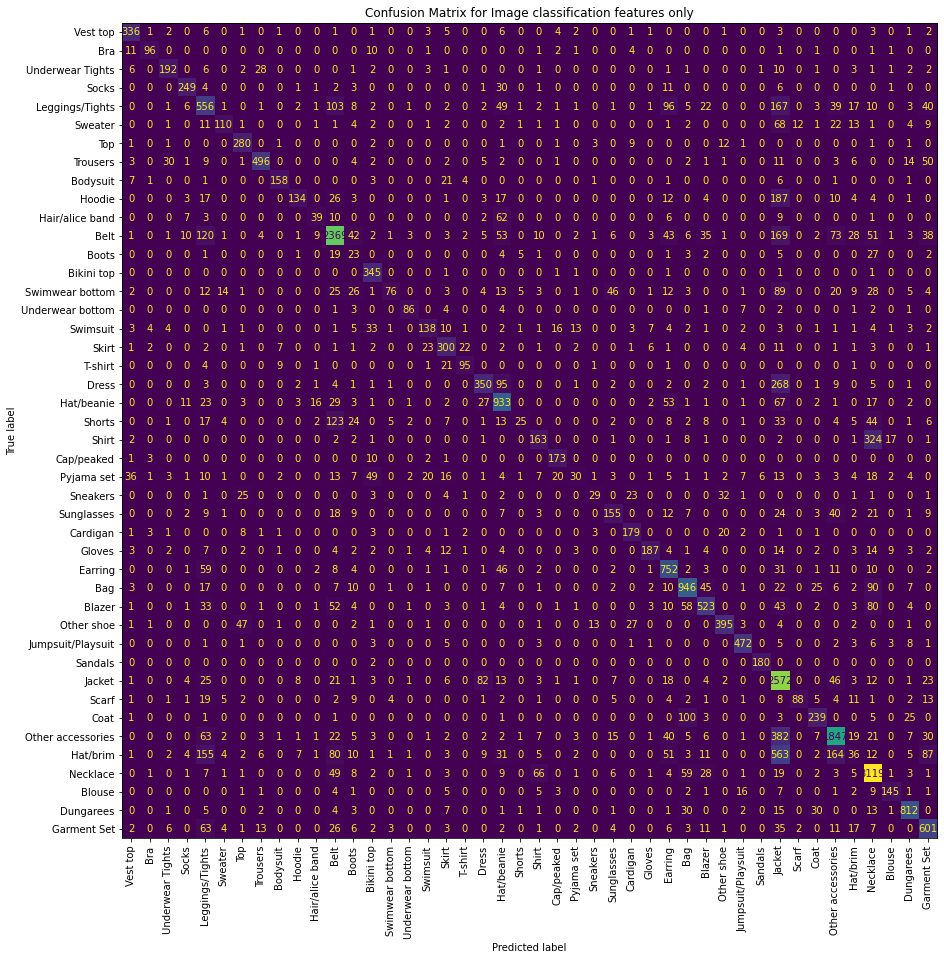

In [68]:
# Display confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
display = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred_image,
        display_labels=product_cat,
        ax=ax, colorbar=False,
#         cmap=plt.cm.Blues,
        xticks_rotation='vertical')
ax.set_title("Confusion Matrix for Image classification features only")


In [61]:
class_labels = list(best_model.classes_)
class_labels

['Bag',
 'Belt',
 'Bikini top',
 'Blazer',
 'Blouse',
 'Bodysuit',
 'Boots',
 'Bra',
 'Cap/peaked',
 'Cardigan',
 'Coat',
 'Dress',
 'Dungarees',
 'Earring',
 'Garment Set',
 'Gloves',
 'Hair/alice band',
 'Hat/beanie',
 'Hat/brim',
 'Hoodie',
 'Jacket',
 'Jumpsuit/Playsuit',
 'Leggings/Tights',
 'Necklace',
 'Other accessories',
 'Other shoe',
 'Pyjama set',
 'Sandals',
 'Scarf',
 'Shirt',
 'Shorts',
 'Skirt',
 'Sneakers',
 'Socks',
 'Sunglasses',
 'Sweater',
 'Swimsuit',
 'Swimwear bottom',
 'T-shirt',
 'Top',
 'Trousers',
 'Underwear Tights',
 'Underwear bottom',
 'Vest top']

### Investigate the incorrectly classified products
Calculate a score called `predicted_label_confidence` which is the difference in the confidence scores given in the SGDC's decision_function for the predicted class vs. the actual product category label. Look at the misclassified examples with the highest score i.e. the ones the model was most sure about but got wrong to see if there are any obvious issues with the model or data.

In [62]:
incorrect_labels_idx = X_test_image[y_test != y_pred_image].index
incorrect_labels_info = df.loc[incorrect_labels_idx][['prod_name','detail_desc','product_type_name']]

In [63]:
incorrect_labels_info['predicted_label'] = y_pred_image[y_test != y_pred_image]

In [64]:
incorrect_labels_info

,prod_name,detail_desc,product_type_name,predicted_label
article_id,,,,
341909049,REBECCA basic tanktop,Vest tops in soft cotton jersey with a scallop...,Vest top,Sweater
387348023,Thales printed tanktop,"Running vest top in printed, fast-drying funct...",Vest top,Sweater
453988024,Eva Tank Top (1),Fitted sports top in fast-drying functional fa...,Vest top,Sweater
472065002,Novak Ruffle Tank,V-neck top in a patterned weave with narrow ad...,Vest top,Blouse
494292001,Cricket top,"Fitted, one-shoulder jersey top.",Vest top,Sweater
...,...,...,...,...
940036002,Knot Set,"Set with a top and pair of leggings in soft, o...",Garment Set,Trousers
940098001,Ilse Long Hood Set.,Set with a hoodie and pair of leggings. Hoodie...,Garment Set,Sweater
940098002,Ilse Long Hood Set.,Set with a hoodie and pair of leggings. Hoodie...,Garment Set,Pyjama set


In [65]:
# Create a dictionary to map product category class to the index of the decision function
class_labels_dict = dict(zip(class_labels,range(len(class_labels))))
class_labels_dict

{'Bag': 0,
 'Belt': 1,
 'Bikini top': 2,
 'Blazer': 3,
 'Blouse': 4,
 'Bodysuit': 5,
 'Boots': 6,
 'Bra': 7,
 'Cap/peaked': 8,
 'Cardigan': 9,
 'Coat': 10,
 'Dress': 11,
 'Dungarees': 12,
 'Earring': 13,
 'Garment Set': 14,
 'Gloves': 15,
 'Hair/alice band': 16,
 'Hat/beanie': 17,
 'Hat/brim': 18,
 'Hoodie': 19,
 'Jacket': 20,
 'Jumpsuit/Playsuit': 21,
 'Leggings/Tights': 22,
 'Necklace': 23,
 'Other accessories': 24,
 'Other shoe': 25,
 'Pyjama set': 26,
 'Sandals': 27,
 'Scarf': 28,
 'Shirt': 29,
 'Shorts': 30,
 'Skirt': 31,
 'Sneakers': 32,
 'Socks': 33,
 'Sunglasses': 34,
 'Sweater': 35,
 'Swimsuit': 36,
 'Swimwear bottom': 37,
 'T-shirt': 38,
 'Top': 39,
 'Trousers': 40,
 'Underwear Tights': 41,
 'Underwear bottom': 42,
 'Vest top': 43}

In [66]:
# Compute the score between predicted label and actual label
predicted_label_scores = best_model.decision_function(X_test_image[y_test != y_pred_image])
article_id_to_idx = dict(zip(incorrect_labels_info.index, range(len(incorrect_labels_info))))
                         
def compute_confidence(row):
    predicted_label_class_idx = class_labels_dict[row['predicted_label']]
    actual_label_class_idx = class_labels_dict[row['product_type_name']]
    idx = article_id_to_idx[row.name]
    return predicted_label_scores[idx, predicted_label_class_idx] - predicted_label_scores[idx, actual_label_class_idx]
    
incorrect_labels_info['predicted_label_confidence'] = incorrect_labels_info.apply(lambda row: compute_confidence(row), axis=1)

/var/folders/5_/87js___11b5312gjj36qhf_m0000gn/T/ipykernel_77728/3542218536.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,prod_name,detail_desc,product_type_name,predicted_label,predicted_label_confidence,image
article_id,,,,,,
582789001,Ferenz sweater,"Short jumper in a soft, fine knit with shoulder pads, long, slightly wider sleeves with decorative gathers, and ribbing around the neckline, cuffs and hem.",Dress,Sweater,8.846641,
621766001,Alex crew neck,"Long-sleeved top in soft sweatshirt fabric with a print motif on the front and ribbing around the neckline, cuffs and hem. Soft brushed inside.",Cardigan,Sweater,8.833661,
800537001,Full knitted jumper,"Turtleneck jumper in a soft, rib-knit alpaca blend with beaded embroidery at the front, and around the neckline and cuffs. Long balloon sleeves with wide, ribbed cuffs, and a ribbed hem.",Dress,Sweater,8.808888,
661650003,ERICA earcuff pack,Set with three pairs of studs and four ear cuffs made of metal in various sizes and designs.,Other accessories,Earring,8.785362,
560819002,Lovi Beanie,"Double-layered hat in a soft, fine knit containing some wool.",Hat/brim,Hat/beanie,7.992440,

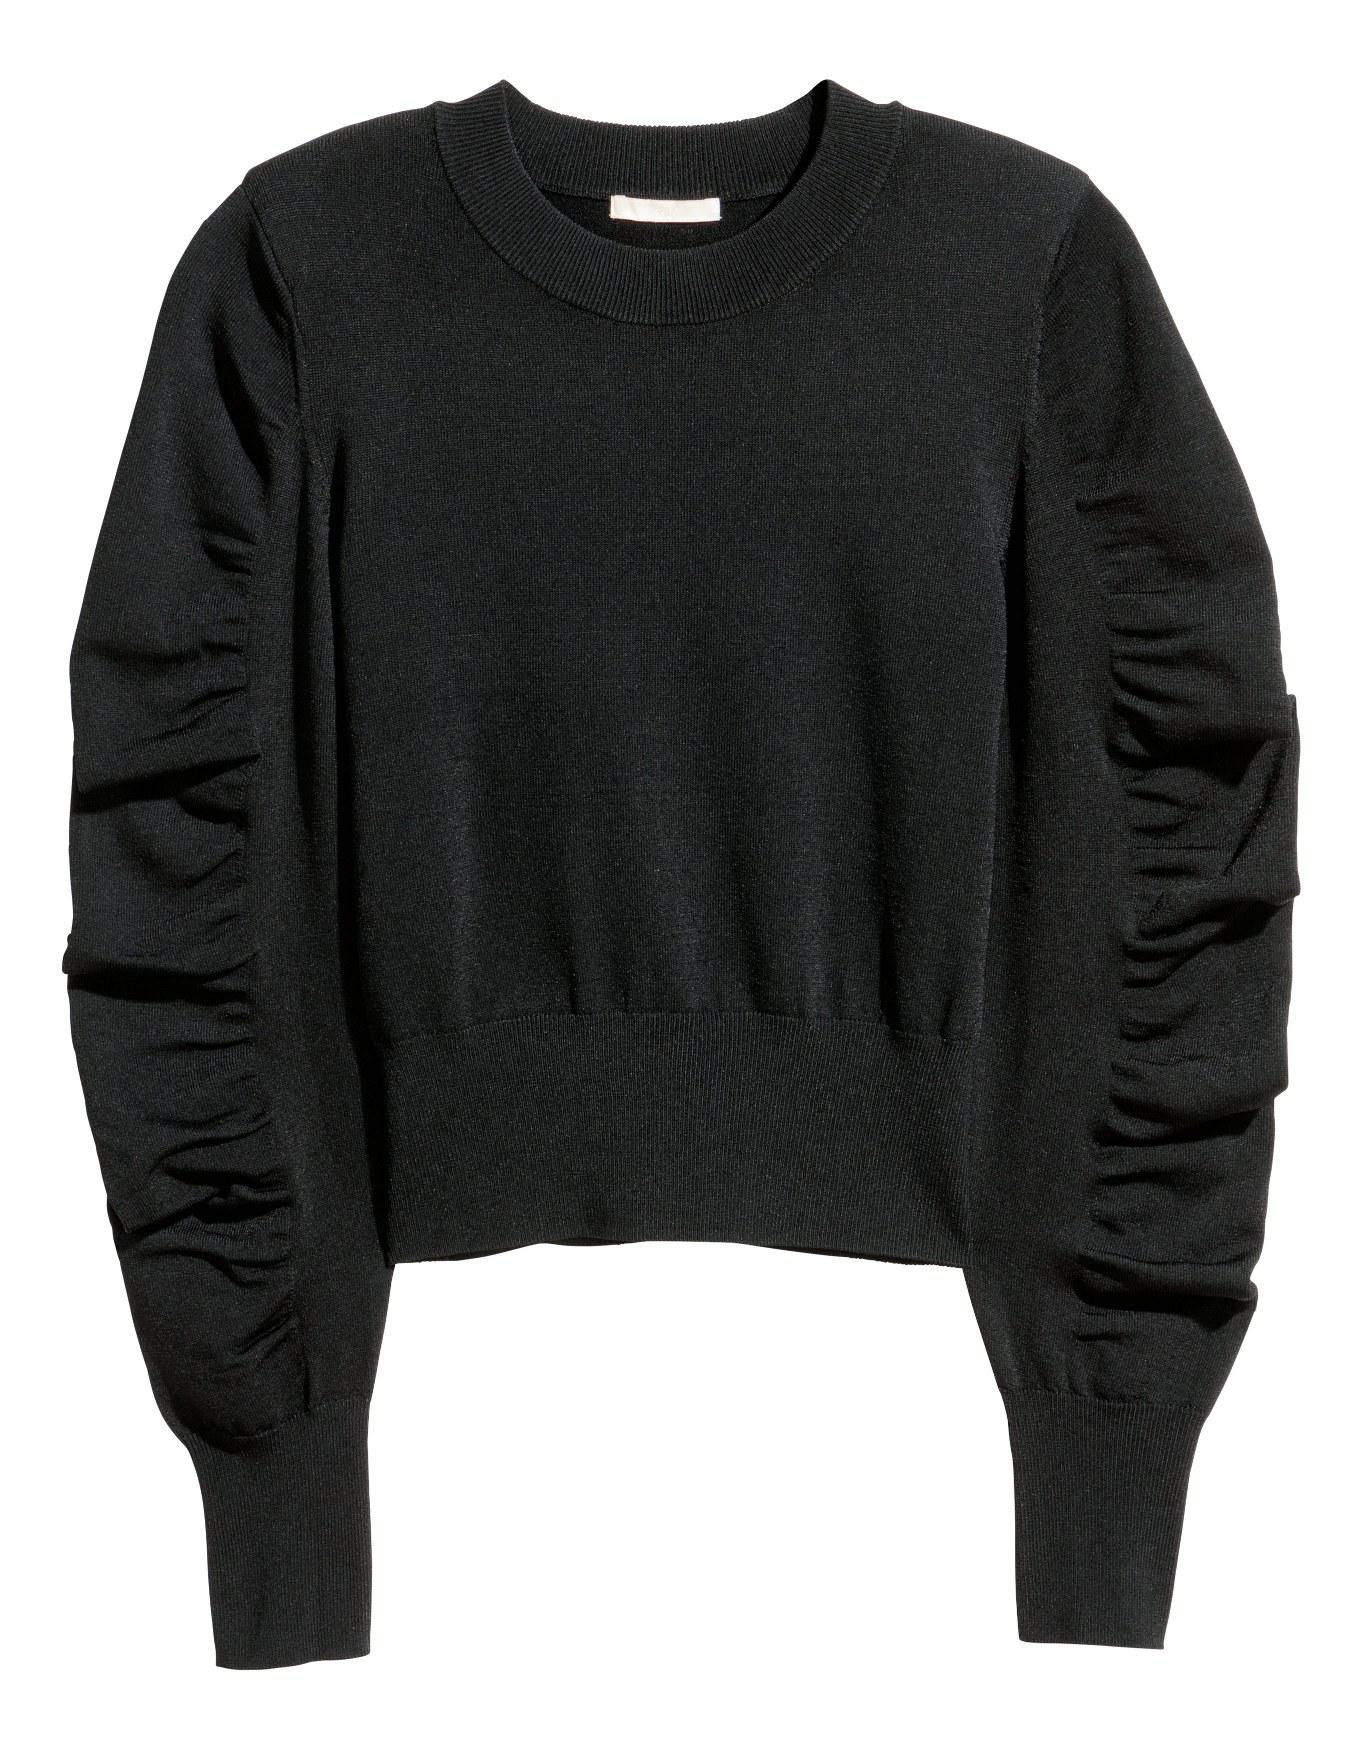
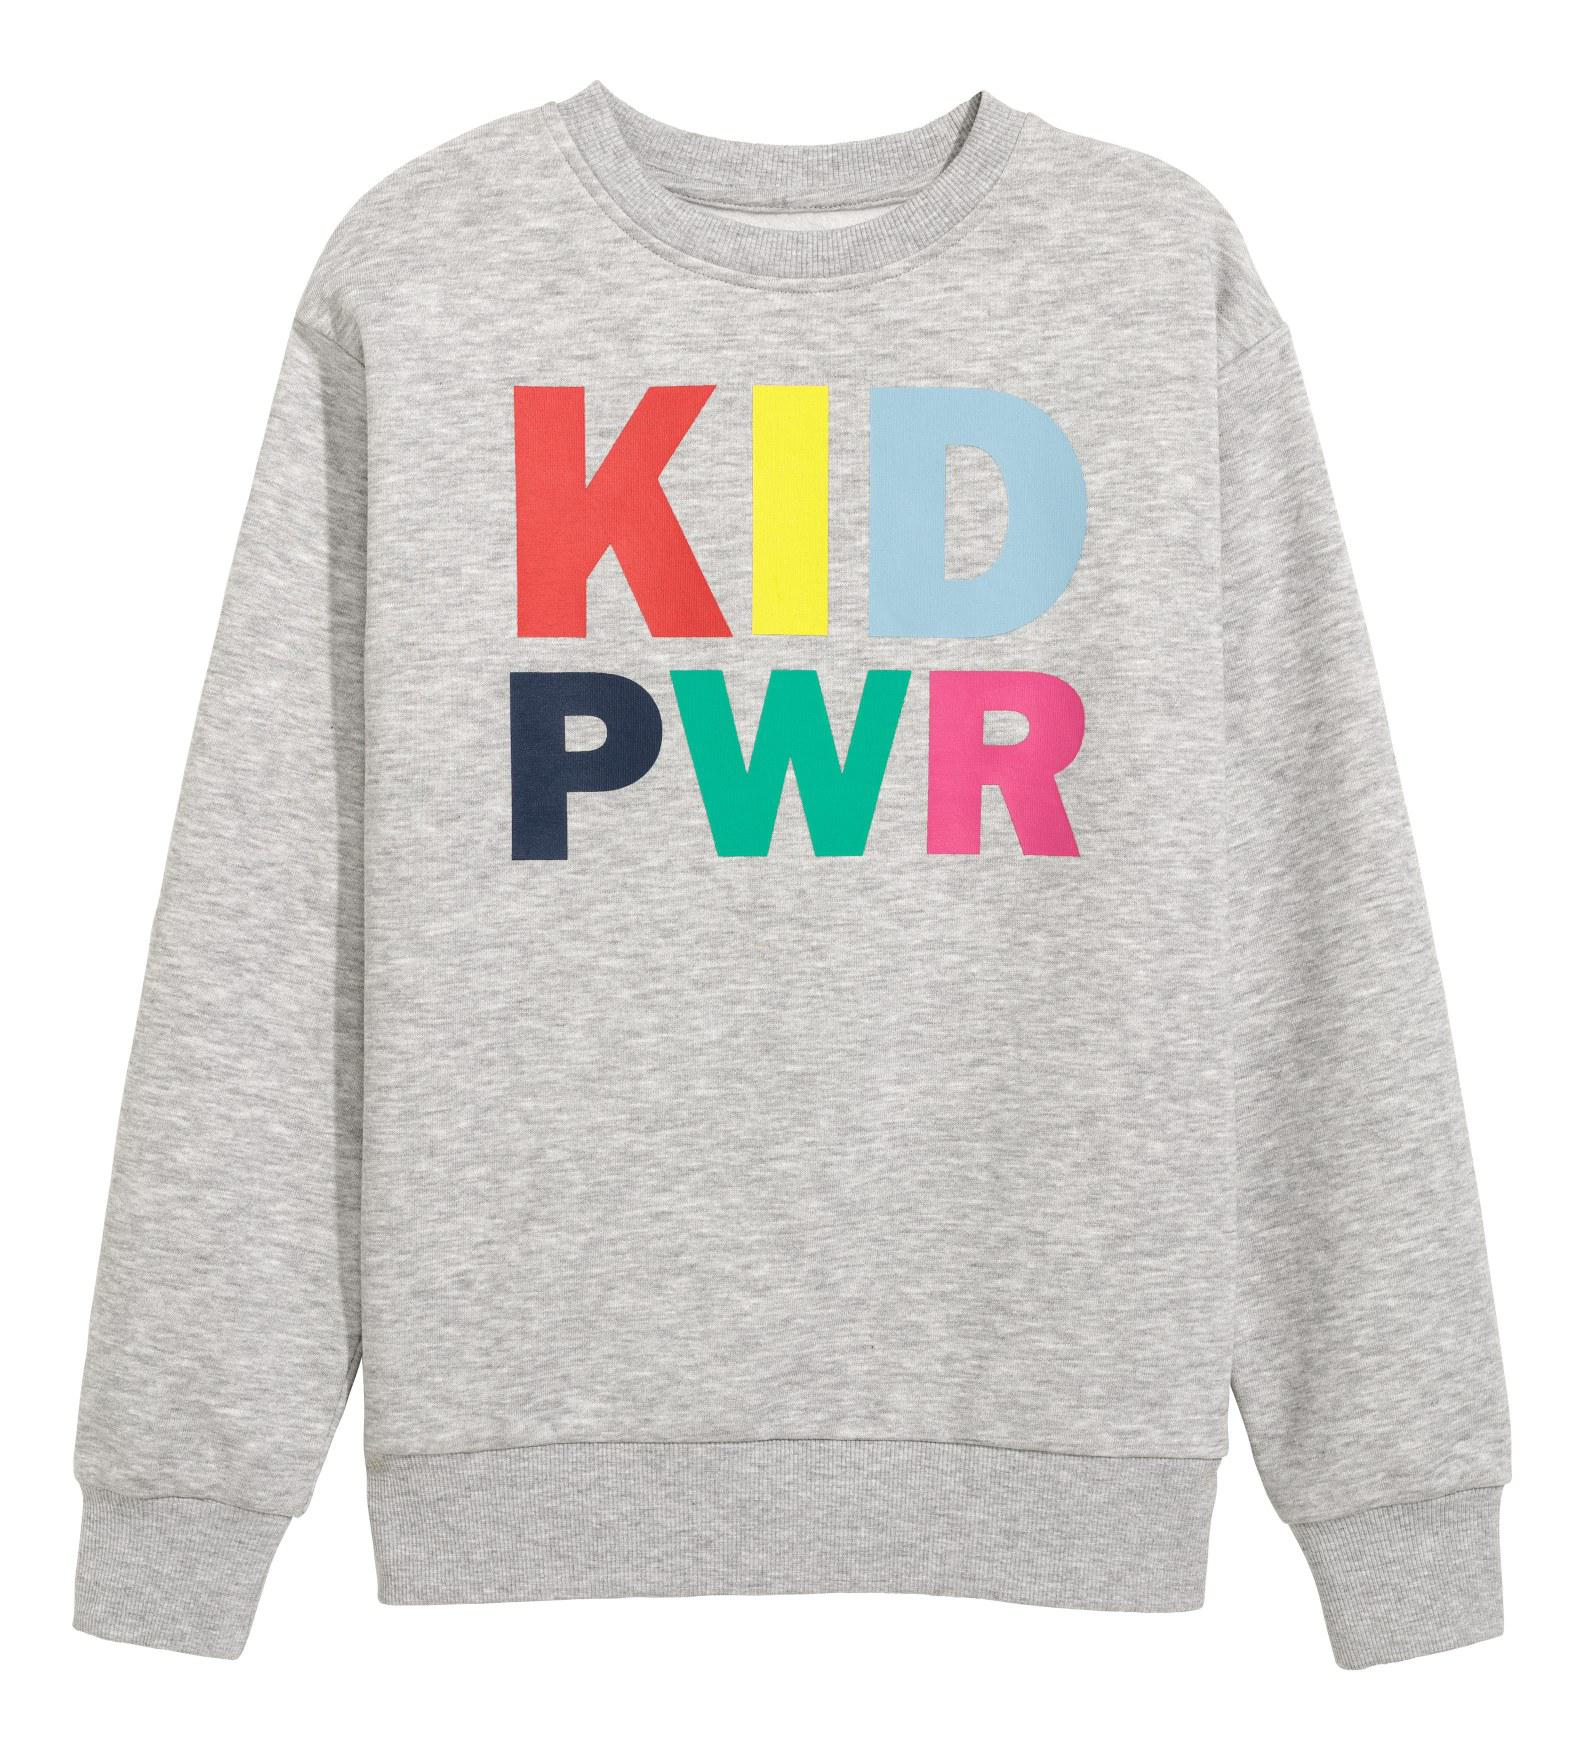
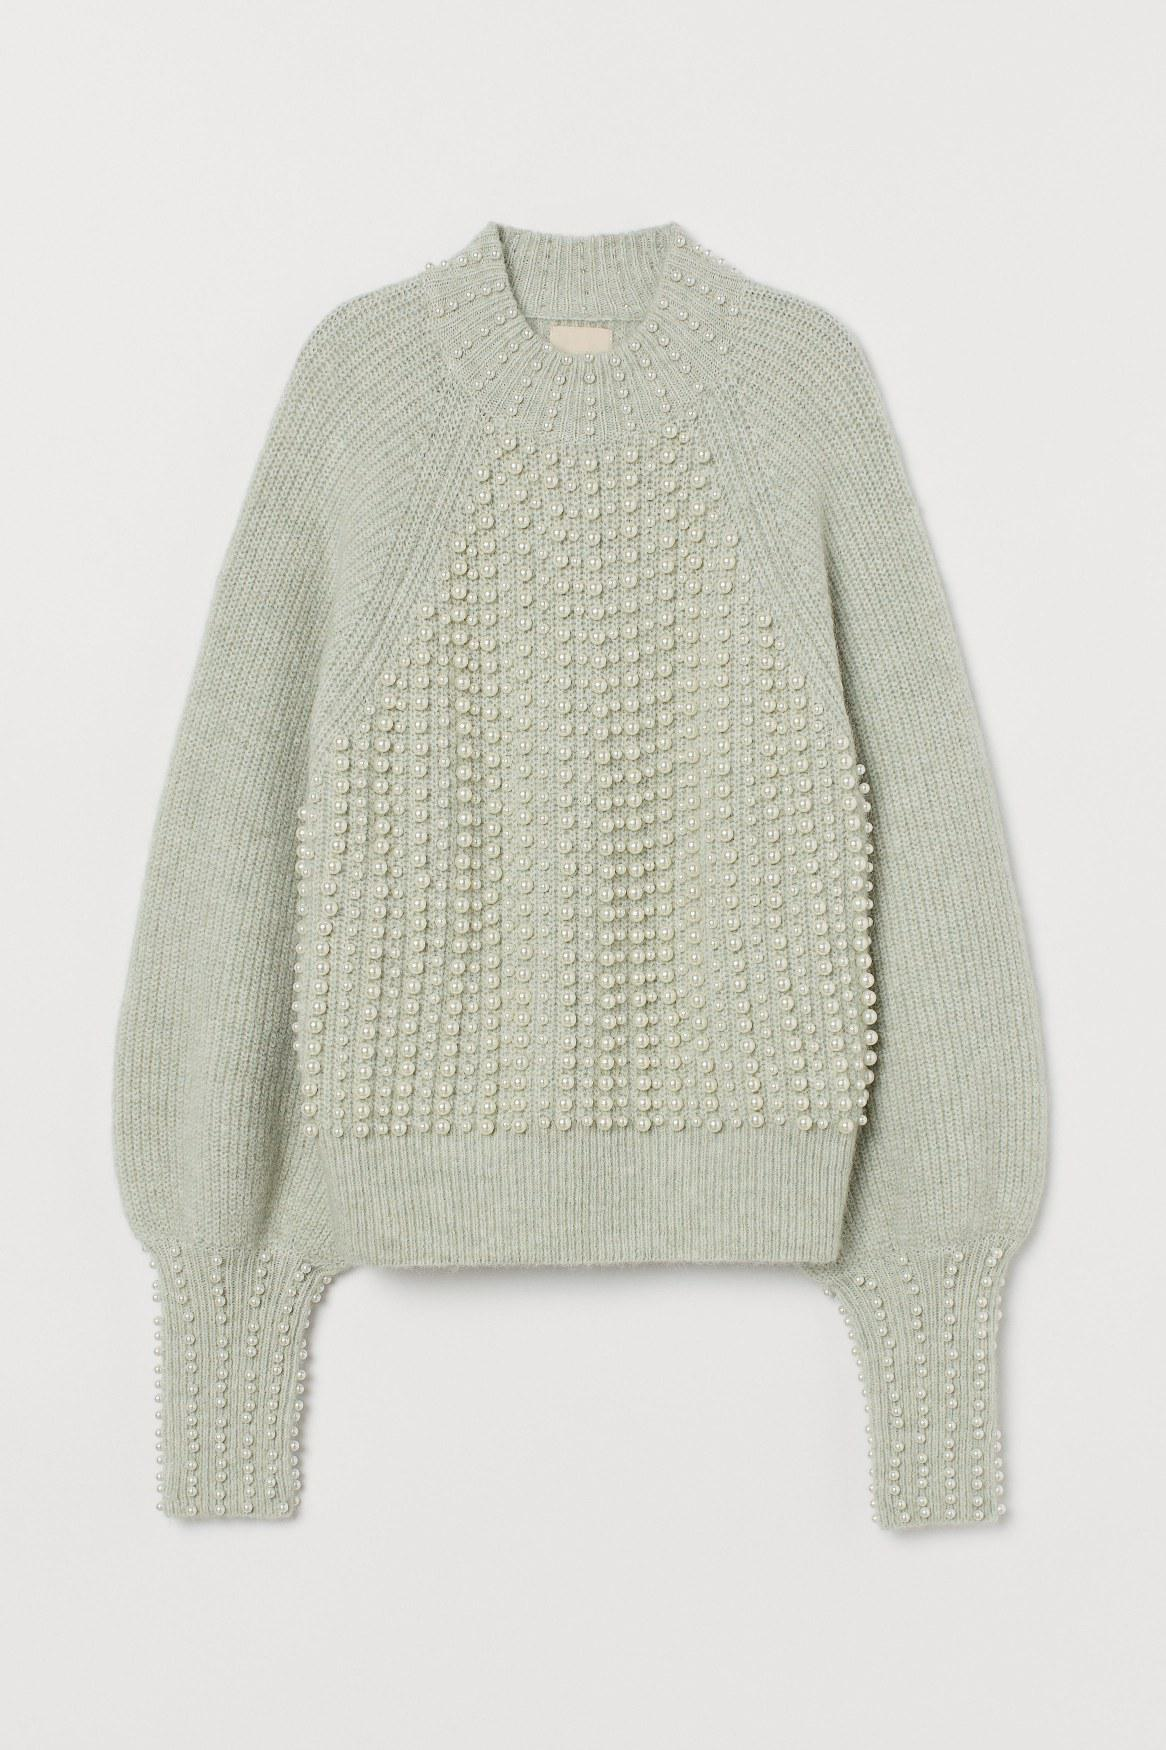
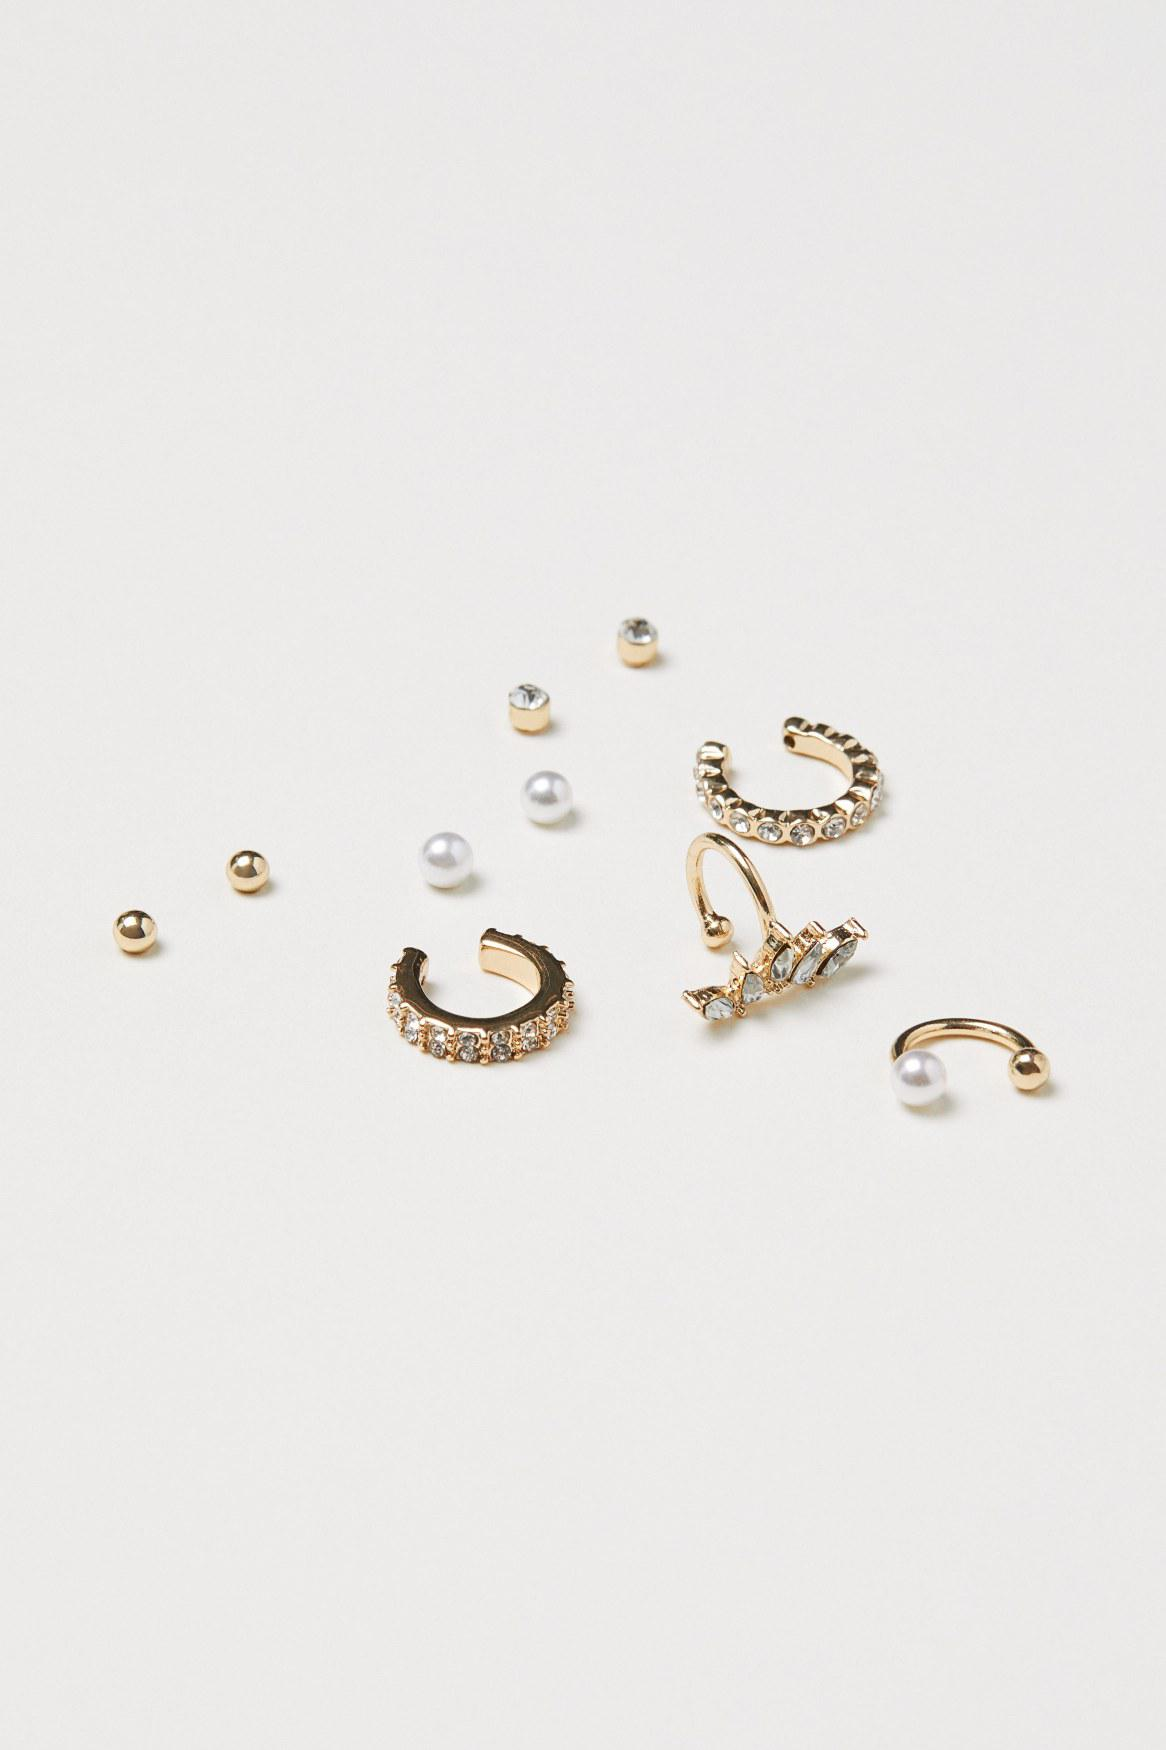
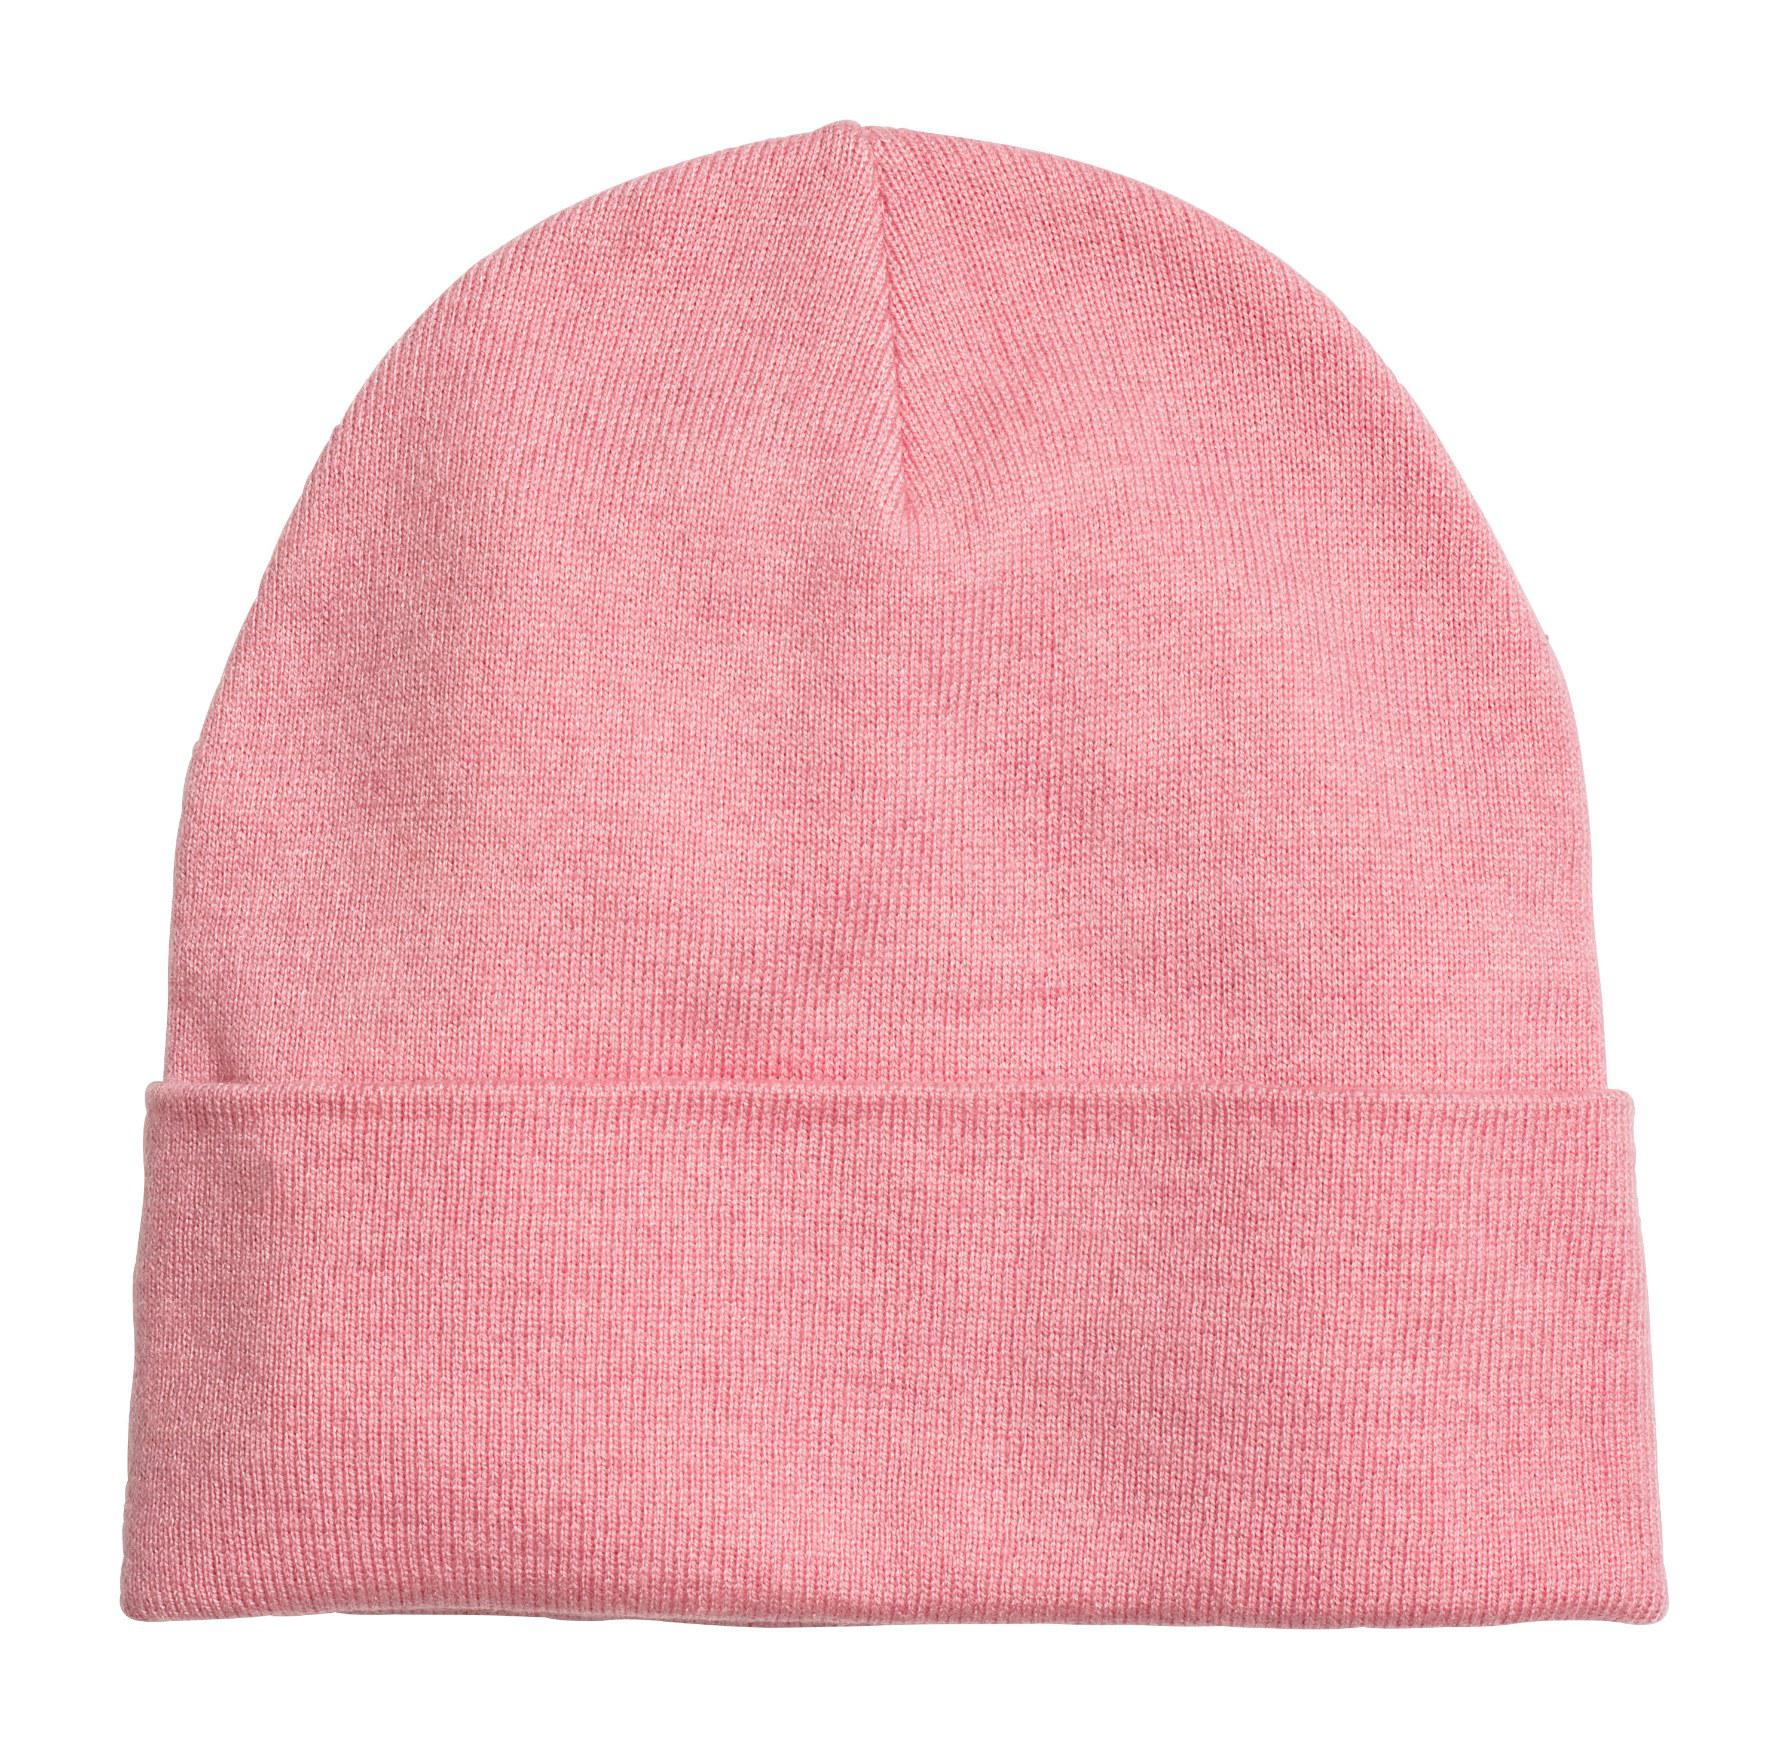

In [67]:
# Plot the product image in the dataframe alongside the predicted class and actual product category

pd.set_option('display.max_colwidth', -1)


def image_base64(im):
    if isinstance(im, str):
        im = Image.open(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()


def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'


def display_images(df, image_col):
    return HTML(df.to_html(formatters={image_col: image_formatter}, escape=False))
    

def get_image_path(article_id):
    article_id = '0' + str(article_id)
    return f'/Users/pandabear/springboard/H_and_M_product_category_classification/data/raw/{article_id[:3]}/{article_id}.jpg'


# Only display a small number of rows otherwise image processing is too slow.
incorrect_labels_info_sample = incorrect_labels_info.sort_values('predicted_label_confidence', ascending=False).head()
incorrect_labels_info_sample['image'] = incorrect_labels_info_sample.index.map(get_image_path)
display_images(incorrect_labels_info_sample, 'image')

Looking at the examples of misclassified products suggests the product category labels are wrong for some of the rows, e.g. looking at the title, description and image the first product should be a sweater and not a dress. 
Other examples such as Hat/brim but was classified as Hat/beanie are not too far off, but the original label is still incorrect. 
These incorrect product category labels should be corrected, but for now it is good to see that model is actually performing better than the weighted accuray score shown. 

### 2. Product title embeddings only 

In [69]:
X_train_2

,_ls,_fancy,_hw,_slim,_ss,_dress,_tee,_price,_basic,_denim,...,_round,_washed,_buttoned,_loop,_functional,_welt,_slits,_mesh,_belt,_jeans
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108775044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108775051,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218354001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218354020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935667002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
936427001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
942062001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [70]:
sgdc_model = RandomizedSearchCV(SGDClassifier(), param_distributions=param_SGDC, cv=5, random_state=0)

sgdc_model.fit(X_train_2, y_train)
best_model = sgdc_model.best_estimator_
y_pred_2 = best_model.predict(X_test_2)

sgdc_model_2 = classification_report(y_test, y_pred_2, output_dict=True)

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classific

In [71]:
sgdc_model_2['weighted avg']['f1-score']

0.7752606951145403

### 3. Product title + product description embeddings only 


In [72]:

sgdc_model = RandomizedSearchCV(SGDClassifier(), param_distributions=param_SGDC, cv=5, random_state=0)

sgdc_model.fit(X_train_3, y_train)
best_model = sgdc_model.best_estimator_
y_pred_3 = best_model.predict(X_test_3)

sgdc_model_3 = classification_report(y_test, y_pred_3, output_dict=True)

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [73]:
sgdc_model_3['weighted avg']['f1-score']

0.7744378759771054

### 4. Product title + Image classification

In [80]:
# Create a dataset with product titles and image embeddings
X_train_title_image = pd.concat([X_train_2, X_train_image], axis=1)
X_test_title_image = pd.concat([X_test_2, X_test_image], axis=1)
X_train_title_image.head()

,_ls,_fancy,_hw,_slim,_ss,_dress,_tee,_price,_basic,_denim,...,502,503,504,505,506,507,508,509,510,511
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,0,0,0,0,0,0,0,0,0,0,...,0.283601,0.502333,0.815049,0.183200,1.749047,1.393814,0.003090,3.470509,0.953905,1.414786
108775044,0,0,0,0,0,0,0,0,0,0,...,0.369955,0.305547,0.750164,0.278698,3.498078,1.059729,0.080655,0.457405,0.473151,1.298293
108775051,0,0,0,0,0,0,0,0,0,0,...,0.673954,1.023912,1.220658,0.990421,0.603554,1.449252,0.105316,2.191562,2.410787,0.329729
218354001,0,0,0,0,0,0,0,0,0,0,...,0.341016,0.502954,0.548671,0.238594,3.445659,1.459554,0.035231,1.851578,0.190741,0.840083
218354020,0,0,0,0,0,0,0,0,0,0,...,0.600791,0.542940,0.179264,0.557903,3.657901,0.666624,0.140613,1.973186,0.912641,1.186398


In [81]:
print(X_train_title_image.shape)
print(len(y_train))
print(X_test_title_image.shape)
print(len(y_test))

(68848, 685)
68848
(30087, 685)
30087


In [83]:
param_SGDC_4 = {
            'penalty':['l2'],
            'alpha':[1e-3, 1e-2, 1e-1],
            'max_iter':[2000],
            'n_jobs': [-1]
            }

sgdc_model = RandomizedSearchCV(SGDClassifier(), param_distributions=param_SGDC_4, cv=5, random_state=0)

sgdc_model.fit(X_train_title_image, y_train)
best_model = sgdc_model.best_estimator_
y_pred_4 = best_model.predict(X_test_title_image)

sgdc_model_4 = classification_report(y_test, y_pred_4, output_dict=True)

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [84]:
sgdc_model_4['weighted avg']['f1-score']

0.8438913110590874

### 5. Product title + product description + Image classification

In [85]:
X_train_full.head()

,0,1,2,3,4,5,6,7,8,9,...,_round,_washed,_buttoned,_loop,_functional,_welt,_slits,_mesh,_belt,_jeans
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,1.671856,0.076411,1.992960,0.515366,0.087093,0.499538,0.125408,0.519581,0.692295,0.194752,...,0,0,0,0,0,0,0,0,0,0
108775044,0.317337,0.022370,0.790894,0.184620,0.122858,0.215203,0.008712,0.393076,0.475337,0.341774,...,0,0,0,0,0,0,0,0,0,0
108775051,0.972625,0.119625,2.423473,1.054603,0.002196,1.429509,0.087665,1.118197,0.183544,0.195096,...,0,0,0,0,0,0,0,0,0,0
218354001,0.559747,0.036349,0.889850,0.460132,0.109168,0.269749,0.181114,0.101232,0.319525,0.182448,...,0,0,0,0,0,0,0,0,0,0
218354020,0.054922,0.070500,1.114768,0.401214,0.079318,0.449255,0.529491,1.079381,0.306888,0.193872,...,0,0,0,0,0,0,0,0,0,0


In [86]:
X_test_full.head()

,0,1,2,3,4,5,6,7,8,9,...,_round,_washed,_buttoned,_loop,_functional,_welt,_slits,_mesh,_belt,_jeans
article_id,,,,,,,,,,,,,,,,,,,,,
194270002,1.620172,0.140583,0.715644,1.140085,0.141574,0.181567,0.266037,0.105068,0.432356,0.120942,...,0,0,0,0,0,0,0,0,0,0
194270044,0.320825,0.479506,0.718964,0.042605,0.000000,0.081761,0.623028,0.474288,1.167822,0.400388,...,0,0,0,0,0,0,0,0,0,0
194270045,1.010420,0.091721,2.454683,0.907387,0.221087,0.308097,0.050207,0.172918,0.420462,0.104838,...,0,0,0,0,0,0,0,0,0,0
194270046,1.020009,0.144256,1.613463,0.537956,0.021299,0.000000,0.799791,0.068291,0.852980,0.262913,...,0,0,0,0,0,0,0,0,0,0
200761022,0.336212,0.256347,1.347251,0.027180,0.021341,0.318473,1.101777,1.023370,0.705725,0.866544,...,0,0,0,0,0,0,0,0,0,0


In [87]:
param_SGDC_5 = {
            'penalty':['l2'],
            'alpha':[1e-3, 1e-2, 1e-1],
            'max_iter':[2000],
            'n_jobs': [-1]
            }

sgdc_model = RandomizedSearchCV(SGDClassifier(), param_distributions=param_SGDC_5, cv=5, random_state=0)

sgdc_model.fit(X_train_full, y_train)
best_model = sgdc_model.best_estimator_
y_pred = best_model.predict(X_test_full)

sgdc_model_5 = classification_report(y_test, y_pred, output_dict=True)
sgdc_model_5

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'Bag': {'precision': 0.8989637305699482,
  'recall': 0.910761154855643,
  'f1-score': 0.9048239895697523,
  'support': 381},
 'Belt': {'precision': 0.7945205479452054,
  'recall': 0.8923076923076924,
  'f1-score': 0.8405797101449275,
  'support': 130},
 'Bikini top': {'precision': 0.8659003831417624,
  'recall': 0.8528301886792453,
  'f1-score': 0.8593155893536122,
  'support': 265},
 'Blazer': {'precision': 0.8140845070422535,
  'recall': 0.932258064516129,
  'f1-score': 0.869172932330827,
  'support': 310},
 'Blouse': {'precision': 0.7725118483412322,
  'recall': 0.8548951048951049,
  'f1-score': 0.8116182572614108,
  'support': 1144},
 'Bodysuit': {'precision': 0.8974358974358975,
  'recall': 0.7720588235294118,
  'f1-score': 0.8300395256916997,
  'support': 272},
 'Boots': {'precision': 0.9283154121863799,
  'recall': 0.8248407643312102,
  'f1-score': 0.8735244519392918,
  'support': 314},
 'Bra': {'precision': 0.8410041841004184,
  'recall': 0.9363354037267081,
  'f1-score': 0.88

In [88]:
sgdc_model_5['weighted avg']['f1-score']

0.8519492239786441

In [89]:
# Create a table summarizing the metrics for each SDGC variant
sgdc_results = {'features':['Image','Product title','Product title + product description','Product title + Image classification','Product title + product description + image'],
               'weighted avg f1-score':[sgdc_model_1['weighted avg']['f1-score'],sgdc_model_2['weighted avg']['f1-score'],sgdc_model_3['weighted avg']['f1-score'],sgdc_model_4['weighted avg']['f1-score'],sgdc_model_5['weighted avg']['f1-score']]}

sgdc_results = pd.DataFrame(sgdc_results)
sgdc_results


,features,weighted avg f1-score
0,Image,0.677651
1,Product title,0.775261
2,Product title + product description,0.774438
3,Product title + Image classification,0.843891
4,Product title + product description + image,0.851949


These combinations shows that classification using image only performs the worst. 
Product title performs about the same as product title + description and that product description doesnt add much additional information to the model. 

Product title + description + images performs only slightly better than title + images, so to simplify the model and reduce dimensionality, drop the description features. 

Subsequent models will use product title and image embeddings only.

### XGBoost


In [92]:
y_train

['Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',
 'Vest top',

In [93]:
lab = LabelEncoder()

#perform label encoding on 'team' column
y_train_encoded = lab.fit_transform(y_train)
y_test_encoded = lab.transform(y_test)
y_test_encoded


array([43, 43, 43, ..., 14, 14, 14])

In [94]:
y_train_encoded

array([43, 43, 43, ..., 14, 14, 14])

In [95]:
xgb_clf = xgb.XGBClassifier()

parameters = {
    'objective': 'multi:softprob',  # error evaluation for multiclass tasks
    'max_depth': [3,6],  # depth of the trees in the boosting process
    'min_child_weight':[1,2]
#     'gamma':[0,1]
    }  
num_round = 20  # the number of training iterations

xgb_clf.fit(X_train_title_image, 
            y_train_encoded,
            verbose=1)# set to 1 to see xgb training round intermediate results)

KeyboardInterrupt: 

In [ ]:
classification_report(y_test_encoded, xgb_clf.predict(X_test_title_image), output_dict=True)['weighted avg']['f1-score']


# This is taking too long to run

In [247]:
# Random Search
param_grid_xgb = {
    "max_depth": [3],
    "learning_rate": [0.1, 0.5, 1, 1.5],
}
#    'objective':['multi:softmax']
xgb_random_cv = RandomizedSearchCV(xgb.XGBClassifier(), param_grid_xgb, n_jobs=-1, cv=5, scoring='f1_micro', random_state=0)
#scoring="roc_auc"

# Fit
best_model_xgb =  xgb_random_cv.fit(X_train_title_image, y_train_encoded)

# print(best_model_xgb.best_params_)
# best_model_xgb = xgb_random_cv.best_estimator_
# y_pred_xgb = best_model_xgb.predict(X_test_full)
# xgb_model_4 = classification_report(y_test, y_pred_xgb, output_dict=True)
# xgb_model_4

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Predict
y_pred_xgb = best_model_xgb.predict(X_test_title_image)

# Score
accuracy_score(y_test_encoded, y_pred_xgb)

In [ ]:
print(classification_report(y_test_encoded, y_pred_xgb))

### KNN Classifier 


In [158]:
X_test_full.head()

,0,1,2,3,4,5,6,7,8,9,...,_mesh,_print,_motif,_socks,_welt,_sports,_loop,_insoles,_briefs,_inner
article_id,,,,,,,,,,,,,,,,,,,,,
194270002,1.620172,0.140583,0.715644,1.140085,0.141574,0.181567,0.266037,0.105068,0.432356,0.120942,...,0,0,0,0,0,0,0,0,0,0
194270044,0.320825,0.479506,0.718964,0.042605,0.000000,0.081761,0.623028,0.474288,1.167822,0.400388,...,0,0,0,0,0,0,0,0,0,0
194270045,1.010420,0.091721,2.454683,0.907387,0.221087,0.308097,0.050207,0.172918,0.420462,0.104838,...,0,0,0,0,0,0,0,0,0,0
194270046,1.020009,0.144256,1.613463,0.537956,0.021299,0.000000,0.799791,0.068291,0.852980,0.262913,...,0,0,0,0,0,0,0,0,0,0
261606001,0.315765,0.022257,0.577827,0.080765,0.305434,0.073274,0.268229,0.258620,0.452692,0.126100,...,0,0,0,0,0,0,0,0,0,0


In [248]:
knn_clf = KNeighborsClassifier()

knn_params = {'n_neighbors':[3,5,10],
              'p':[1]
             }
#'weights':['uniform', 'distance'],
knn_random_cv = RandomizedSearchCV(knn_clf,param_distributions = knn_params, n_jobs=-1, cv=5, scoring='f1_micro')
#, scoring="roc_auc"

knn_random_cv.fit(X_train_full,y_train)

best_model_knn = knn_random_cv.best_estimator_

y_pred_knn = best_model_knn.predict(X_test_full)
print(classification_report(y_test, y_pred_knn))

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


                   precision    recall  f1-score   support

              Bag       0.83      0.78      0.80        86
             Belt       0.85      0.79      0.81        42
       Bikini top       0.87      0.73      0.80        83
           Blazer       0.80      0.89      0.84       106
           Blouse       0.36      0.42      0.39       299
         Bodysuit       0.52      0.63      0.57        73
            Boots       0.65      0.80      0.72        71
              Bra       0.91      0.91      0.91       245
       Cap/peaked       0.70      0.77      0.73        57
         Cardigan       0.51      0.53      0.52       118
             Coat       0.36      0.28      0.31        29
            Dress       0.62      0.72      0.67       646
        Dungarees       0.62      0.19      0.29        26
          Earring       0.82      0.69      0.75        45
      Garment Set       0.62      0.07      0.12        74
           Gloves       0.73      0.71      0.72       